In [ ]:
import numpy as np
import pandas as pd
import cv2
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import time, random
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3, Xception, InceptionResNetV2,DenseNet121, MobileNet, MobileNetV2

In [ ]:
files_path = '/content/drive/MyDrive/COVID_DATASET'
files_path = pathlib.Path(files_path)
files_path

PosixPath('/content/drive/MyDrive/COVID_DATASET')

In [ ]:
dictionary = {
    'covid': list(files_path.glob('COVID/*')),
    'pneumonia': list(files_path.glob('PNEUMONIA/*')),
}
images_dict = {
    'covid_pneumonia': dictionary['covid'] + dictionary['pneumonia'],
    'healthy': list(files_path.glob('HEALTHY/*'))
}
labels_dict = {
    'covid_pneumonia': 0,
    'healthy': 1,
}

In [ ]:
IMAGE_SHAPE = (224, 224)
X, y = [], []
for name, images in images_dict.items():
    for image in images:
        img = cv2.imread(str(image), 1)
        resized_img = cv2.resize(img, dsize=IMAGE_SHAPE)
        blurred_img = cv2.GaussianBlur(resized_img, ksize=(3, 3), sigmaX=0.5, sigmaY=0.7,
                                       borderType=cv2.BORDER_CONSTANT)
        hsv_img = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2HSV)
        h, s, v = hsv_img[:, :, 0], hsv_img[:, :, 1], hsv_img[:, :, 2]
        value = 10
        limit = 255 - value
        v[v > limit] = 255
        v[v <= limit] += value
        hsv_img_new = cv2.merge((h, s, v))
        img_brightness = cv2.cvtColor(hsv_img_new, cv2.COLOR_HSV2RGB)
        img_brightness_gray = cv2.cvtColor(img_brightness, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
        img_hist_gray = clahe.apply(img_brightness_gray)
        img_hist = cv2.cvtColor(img_hist_gray, cv2.COLOR_GRAY2RGB)
        X.append(img_hist)
        y.append(labels_dict[name])

X = np.array(X)
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape

(1128, 224, 224, 3)

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    height_shift_range=0.2,
    width_shift_range=0.2,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2
)

In [ ]:
def model_1(img_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16,3,padding='same',activation='relu',input_shape=(img_shape+(3,))),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32,3,padding='same',activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(3,activation='softmax')
    ])
    return model

def model_2(img_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu',input_shape=(img_shape+(3,))),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

def model_3(img_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu',input_shape=(img_shape+(3,))),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128,3,padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model


def inceptionv3(img_shape):
    model_inception = InceptionV3(include_top=False,weights='imagenet',input_shape=(img_shape+(3,)))
    for layer in model_inception.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        model_inception,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(3,activation='softmax')
    ])
    return model

def mobilenet(img_shape):
    model_mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=(img_shape + (3,)))
    for layer in model_mobilenet.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        model_mobilenet,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

def densenet121(img_shape):
    model_densenet121 = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_shape + (3,)))
    for layer in model_densenet121.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        model_densenet121,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

def xception(img_shape):
    model_xception = Xception(include_top=False, weights='imagenet', input_shape=(img_shape + (3,)))
    for layer in model_xception.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        model_xception,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

def mobilenetv2(img_shape):
    model_mobilenetv2 = MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_shape + (3,)))
    for layer in model_mobilenetv2.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        model_mobilenetv2,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

In [ ]:
model = mobilenet(img_shape=(224,224))
model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               25690624  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 28,921,027
Trainable params: 25,692,163
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
start_time = time.time()
train = model.fit(data_augmentation.flow(X_train, y_train,batch_size=32), epochs=10)
end_time = time.time()

Epoch 1/10
36/36 [==============================] - 14s 385ms/step - loss: 0.2347 - accuracy: 0.9911
Epoch 2/10
36/36 [==============================] - 14s 383ms/step - loss: 0.1475 - accuracy: 0.9947
Epoch 3/10
36/36 [==============================] - 14s 379ms/step - loss: 0.0945 - accuracy: 0.9973
Epoch 4/10
36/36 [==============================] - 14s 381ms/step - loss: 0.0443 - accuracy: 0.9982
Epoch 5/10
36/36 [==============================] - 14s 377ms/step - loss: 0.1434 - accuracy: 0.9956
Epoch 6/10
36/36 [==============================] - 13s 371ms/step - loss: 0.0239 - accuracy: 0.9991
Epoch 7/10
36/36 [==============================] - 14s 374ms/step - loss: 0.0108 - accuracy: 0.9991
Epoch 8/10
36/36 [==============================] - 14s 375ms/step - loss: 0.0013 - accuracy: 0.9991
Epoch 9/10
36/36 [==============================] - 14s 378ms/step - loss: 0.1113 - accuracy: 0.9991
Epoch 10/10
36/36 [==============================] - 13s 372ms/step - loss: 0.1006 - accura

In [ ]:
training_time = end_time - start_time
training_time

137.6889774799347

In [ ]:
test = model.evaluate(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


12/12 [==============================] - 2s 111ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [ ]:
y_pred = model.predict(X_test)
y_pred = [np.argmax(i) for i in y_pred]
y_pred = np.array(y_pred)

In [ ]:
# Classification Report
cr = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
df_cr = pd.DataFrame(cr).transpose()
df_cr = df_cr.rename(index={'0': 'Covid-19 + Pneumonia', '1': 'Healthy'})
df_cr

,precision,recall,f1-score,support
Covid-19 + Pneumonia,1.0,1.0,1.0,262.0
Healthy,1.0,1.0,1.0,114.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,376.0
weighted avg,1.0,1.0,1.0,376.0


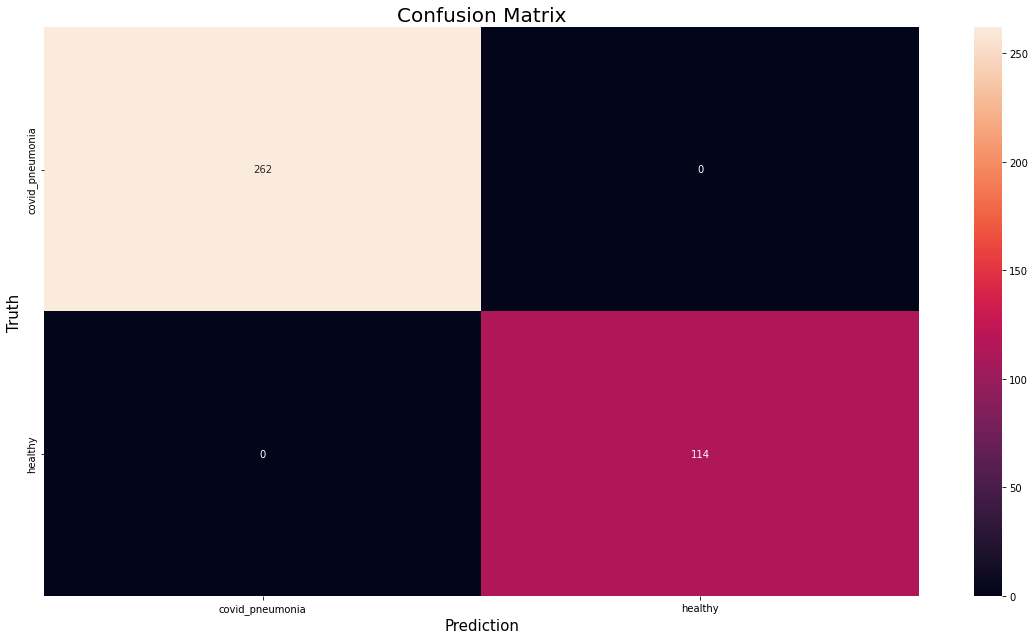

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[i for i, j in labels_dict.items()], columns=[i for i, j in labels_dict.items()])
fig = plt.figure(figsize=(16, 9))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.tight_layout()
plt.show()

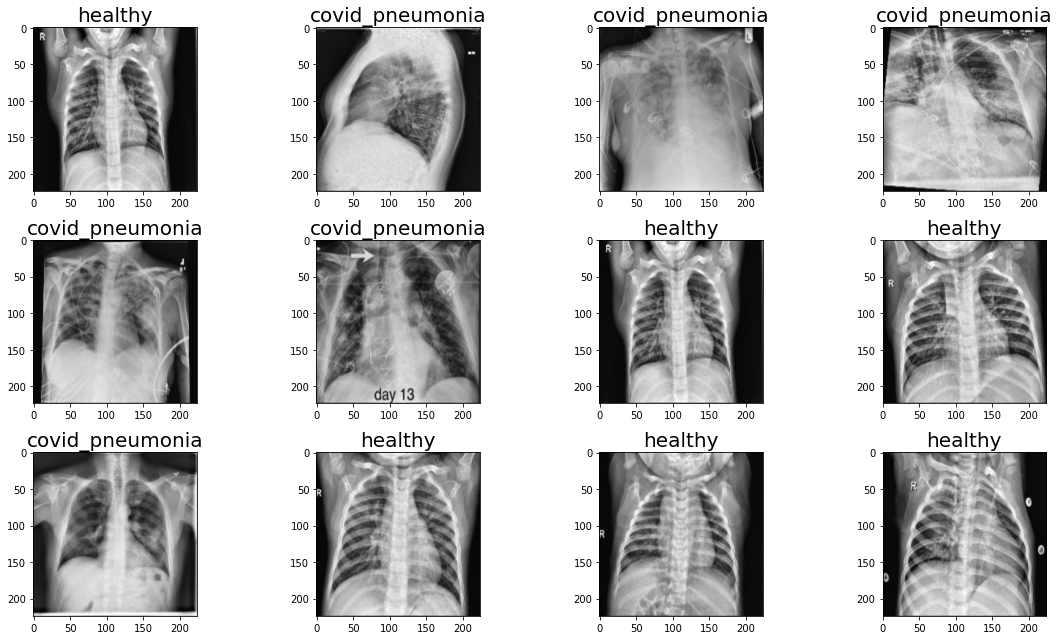

In [ ]:
labels = list(map(lambda x: 'a', range(0, len(y_test))))
first_labels = [i for i, j in labels_dict.items()]
for i in range(len(y_test)):
    if y_test[i] == y_pred[i]:
        labels[i] = first_labels[y_pred[i]]
    elif y_test[i] == 0 and y_pred[i] == 1:
        labels[i] = 'True: Covid-19 or Pneumonia \nPredict: Healthy'
    elif y_test[i] == 1 and y_pred[i] == 0:
        labels[i] = 'True: Healthy\nPredict: Covid-19 or Pneumonia'
    

r = 3
c = 4
fig, axes = plt.subplots(r, c, figsize=(16, 9))
for i in range(0, r):
    for j in range(0, c):
        rand = random.randint(0, len(X_test))
        axes[i, j].imshow(X_test[rand])
        axes[i, j].set_title(labels[rand], fontsize=20)
plt.tight_layout()
plt.show()

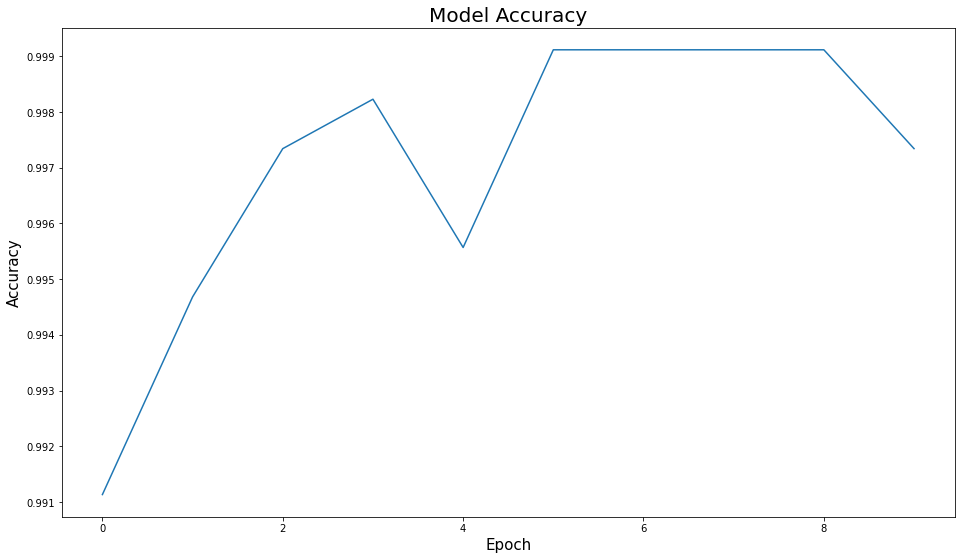

In [ ]:
n_epochs = len(train.history['accuracy'])
fig_acc = plt.figure(0, figsize=(16, 9))
plt.plot(range(n_epochs), train.history['accuracy'])
plt.title('Model Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.show()

Text(0, 0.5, 'Loss')

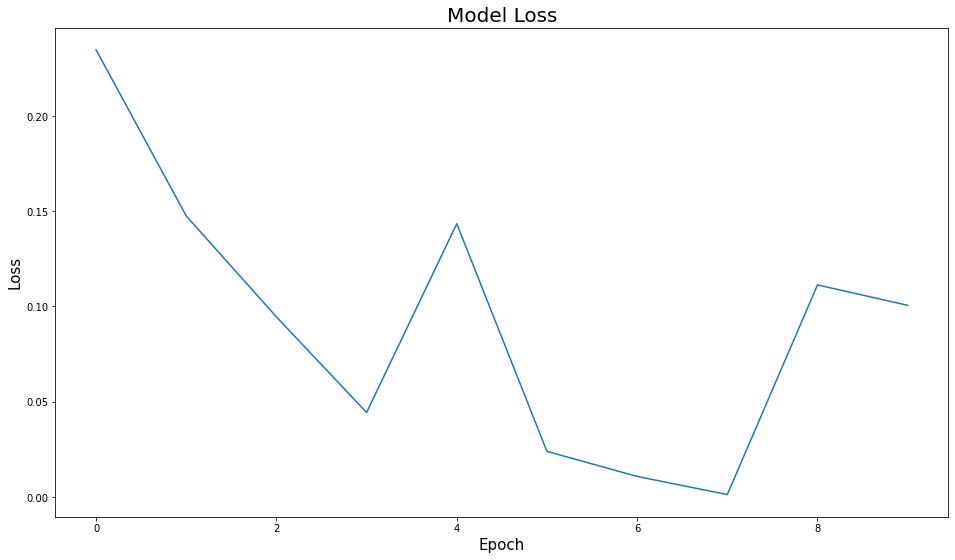

In [ ]:
fig_loss = plt.figure(1, figsize=(16, 9))
plt.plot(range(n_epochs), train.history['loss'])
plt.title('Model Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)

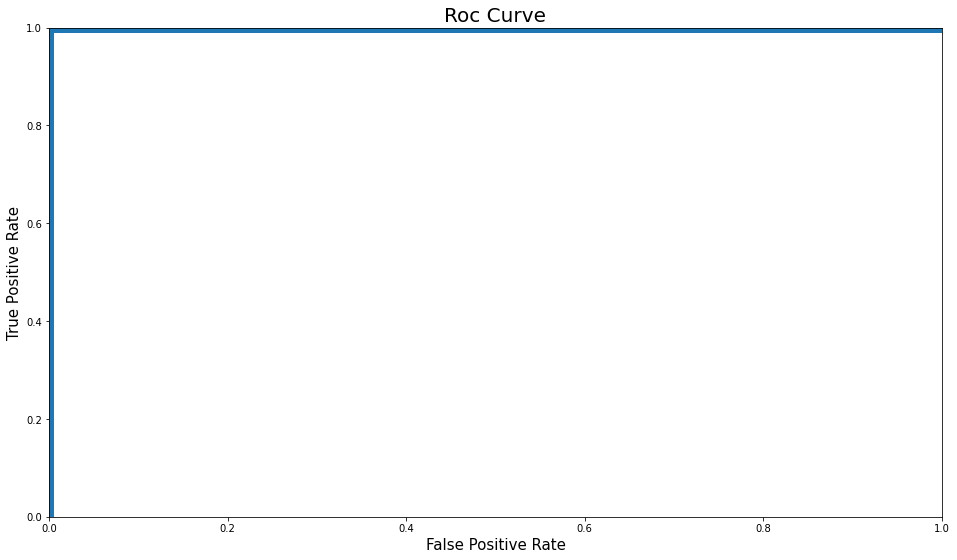

In [ ]:
fpr,tpr,_ = roc_curve(y_test,y_pred)
plt.figure(figsize=(16,9))
plt.plot(fpr,tpr,linewidth = 10)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Roc Curve', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.show()